In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from math import sqrt
import warnings
warnings.filterwarnings("ignore")

In [20]:
# Load & Preprocess Data
df = pd.read_csv("/kaggle/input/time-series-forecasting-with-yahoo-stock-price/yahoo_stock.csv", parse_dates=["Date"]) #use date as index
df = df.sort_values("Date") #sort date wise
data = df["Close"].values #use close as target

In [21]:
# Train-Test Split (80-20)
train_size = int(len(data) * 0.8)
train, test = data[:train_size], data[train_size:]

**ARIMA Model**

In [22]:
from statsmodels.tsa.arima.model import ARIMA

In [23]:
# Fit ARIMA model
arima_model = ARIMA(train, order=(5,1,0))
arima_fit = arima_model.fit()

In [24]:
def sliding_arima(train, test, order=(5,1,0), window_size=None):
    """
    train: training series
    test: testing series
    order: ARIMA order (p,d,q)
    window_size: fixed window size (if None, uses expanding window)
    """
    history = list(train)
    predictions = []

    for t in range(len(test)):
        # Define window (sliding or expanding)
        if window_size:
            input_data = history[-window_size:]
        else:
            input_data = history

        # Fit ARIMA on current window
        model = ARIMA(input_data, order=order)
        model_fit = model.fit()

        # Forecast 1 step ahead
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)

        # Append actual value (rolling forward)
        history.append(test[t])

    # Evaluate
    rmse = sqrt(mean_squared_error(test, predictions))
    return predictions, rmse


In [25]:
arima_preds, arima_rmse_sliding = sliding_arima(train, test, order=(5,1,0), window_size=30)
print("Sliding Window ARIMA RMSE:", arima_rmse_sliding)

Sliding Window ARIMA RMSE: 59.01616273582568


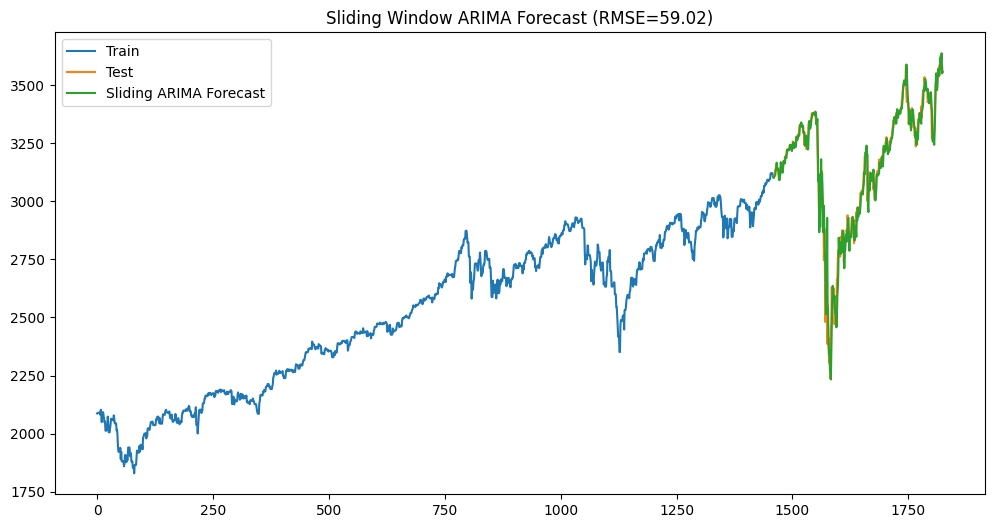

In [26]:
plt.figure(figsize=(12,6))
plt.plot(range(len(train)), train, label="Train")
plt.plot(range(len(train), len(train)+len(test)), test, label="Test")
plt.plot(range(len(train), len(train)+len(test)), arima_preds, label=f"Sliding ARIMA Forecast")
plt.title(f"Sliding Window ARIMA Forecast (RMSE={arima_rmse_sliding:.2f})")
plt.legend()
plt.show()

**LSTM Model**

In [27]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.callbacks import EarlyStopping

In [28]:
# Scale data for LSTM
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data.reshape(-1,1))

train_scaled, test_scaled = scaled_data[:train_size], scaled_data[train_size:]

In [29]:
# Sliding Window Function
def create_dataset(dataset, window=30):
    X, y = [], []
    for i in range(len(dataset)-window):
        X.append(dataset[i:i+window, 0])
        y.append(dataset[i+window, 0])
    return np.array(X), np.array(y)

window = 30
X_train, y_train = create_dataset(train_scaled, window)
X_test, y_test = create_dataset(test_scaled, window)

In [30]:
# Reshape for LSTM [samples, time_steps, features]
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [31]:
# Build LSTM model
lstm_model = Sequential()
# First LSTM layer
lstm_model.add(LSTM(50, activation="relu", return_sequences=True))
# Second LSTM layer
lstm_model.add(LSTM(50, activation="relu"))
# Output layer
lstm_model.add(Dense(1))

# Compile
lstm_model.compile(optimizer="adam", loss="mse")

In [32]:
# Define EarlyStopping
early_stop = EarlyStopping(
    monitor='loss',       
    patience=10,         
    restore_best_weights=True 
)

In [33]:
# Train
history = lstm_model.fit(
    X_train, y_train,
    epochs=100,            
    batch_size=32,
    verbose=1,
    callbacks=[early_stop] 
)

Epoch 1/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 7s 39ms/step - loss: 0.0992
Epoch 2/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0020
Epoch 3/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 6.5521e-04
Epoch 4/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5.3802e-04
Epoch 5/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.4606e-04
Epoch 6/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.9436e-04
Epoch 7/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5.1206e-04
Epoch 8/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.6786e-04
Epoch 9/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.7401e-04
Epoch 10/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.6911e-04
Epoch 11/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.4234e-04
Epoch 12/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.7460e-04
Epoch 13/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.2258e-04
Epoch 14/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.2707e-04
Epoch 15/100
45/45 ━━━

In [34]:
# Predict
lstm_pred = lstm_model.predict(X_test)
lstm_pred_rescaled = scaler.inverse_transform(lstm_pred)

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step


In [35]:
# Actual test values (aligning with window shift)
actual_test = scaler.inverse_transform(y_test.reshape(-1,1))

# RMSE
lstm_rmse = sqrt(mean_squared_error(actual_test, lstm_pred_rescaled))
print("LSTM RMSE:", lstm_rmse)

LSTM RMSE: 55.22332129057016


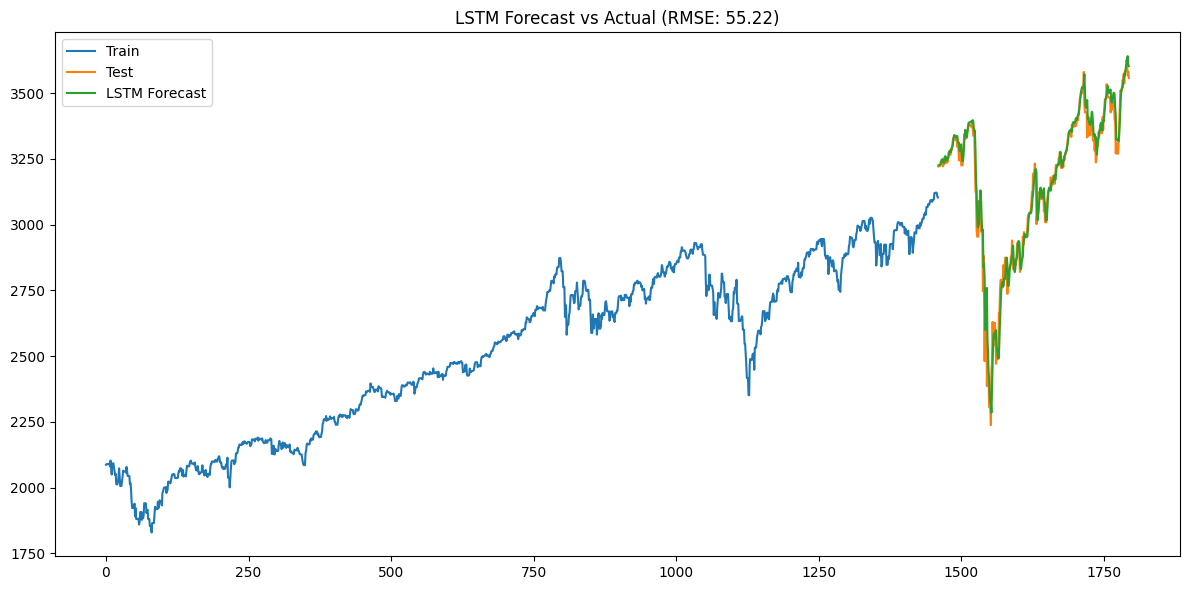

In [36]:
plt.figure(figsize=(12,6))
plt.plot(range(len(train)), train, label="Train")
plt.plot(range(len(train), len(train)+len(actual_test)), actual_test, label="Test")
plt.plot(range(len(train), len(train)+len(lstm_pred_rescaled)), lstm_pred_rescaled, label="LSTM Forecast")
plt.title(f"LSTM Forecast vs Actual (RMSE: {lstm_rmse:.2f})")
plt.legend()

plt.tight_layout()
plt.show()